In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from Utils.utils import low_pass, high_pass
from SoundProject.SoundCard import SoundCard
from SoundProject.SignalAnalysis import SignalAnalysis
from scipy.signal import hilbert

In [2]:
dataRaw = np.loadtxt("Data/penduleData.txt")
dataRaw = dataRaw[11384:]

In [3]:
LENGTH_PENDULUM = 2.82
START_ANGLE = -0.18

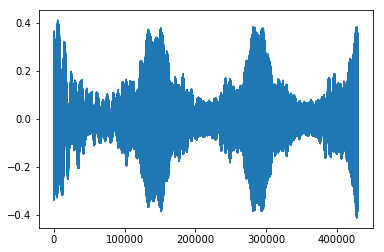

In [4]:
plt.figure()
plt.plot(dataRaw)
plt.show()

Filtering the raw data

In [5]:
dataFiltered = high_pass(dataRaw, 1900, 44100)
dataFiltered = low_pass(dataFiltered, 2100, 44100)

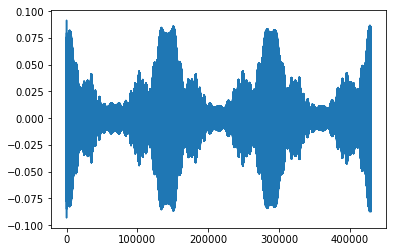

In [6]:
plt.figure()
plt.plot(dataFiltered)
plt.show()

In [7]:
analysisRaw = SignalAnalysis(dataRaw)
analysis = SignalAnalysis(dataFiltered)

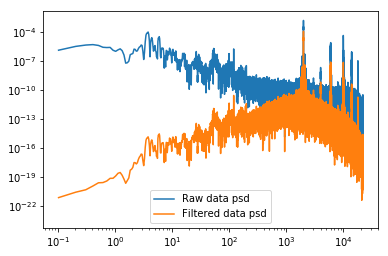

In [8]:
plt.figure()
analysisRaw.plot_psd("Raw data psd")
analysis.plot_psd("Filtered data psd")
plt.legend()
plt.show()

Pendulum simulation :

In [9]:
omega = np.sqrt(9.81/LENGTH_PENDULUM) #Pulsation on the pendulum

In [10]:
t = np.arange(0,10,1/44100) #10 seconds with sampling rate og 44100
vitesse = -START_ANGLE*omega*np.sin(omega *t) #speed of the pendulum function of time
angle = START_ANGLE*np.cos(omega*t) #angle function of time
positionx = LENGTH_PENDULUM*np.sin(angle) #position of the mass function of time
vitesseX = LENGTH_PENDULUM*np.cos(angle)*vitesse #speed on x axis, derivative of positionx

In [11]:
dopplerTest = 2000*(1-vitesseX/340) #theoretical doppler effect function of time
x = np.arange(0, 10*44100)

Extracting frequencies from data

In [12]:
indices, freq = analysis.freq_from_crossings()

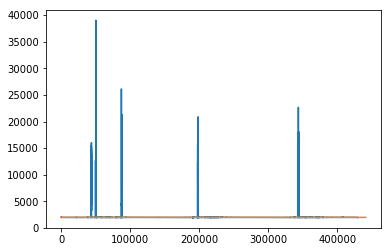

In [13]:
plt.figure()
plt.plot(indices[:-1], freq)
plt.plot(x, dopplerTest)
plt.show()

Trying to fit wiyhout the highest values :

In [14]:
indices2 = []
freq2 = []

#keeping only frequency between 1950 and 2050 Hz
for i in np.arange(0,len(freq)):
    if(freq[i] < 2050 and freq[i] > 1950):
        indices2.append(indices[i])
        freq2.append(freq[i])
        
indices2 = np.array(indices2)
freq2 = np.array(freq2)

Fit with a sinus :

In [15]:
#sinus function centered at 2000Hz
def fit_sin(x, ampl, freq, phase):
    return 2000 + ampl*np.sin(2*np.pi*freq*x+phase)

In [16]:
p_opt, cor_mat = curve_fit(fit_sin, indices2, freq2, (20, 1/150000, 1))
y = fit_sin(indices2, *p_opt)

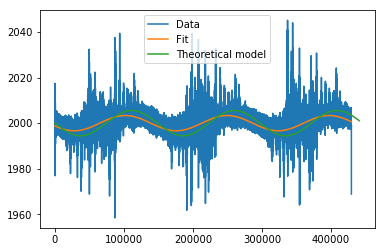

In [17]:
plt.figure()
plt.plot(indices2, freq2, label = 'Data')
plt.plot(indices2, y, label = 'Fit')
plt.plot(x, dopplerTest, label = 'Theoretical model')
plt.legend()
plt.show()

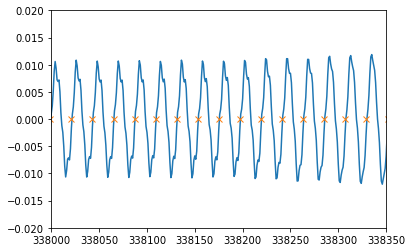

In [18]:
plt.plot(dataFiltered)
plt.plot(indices, np.zeros(len(indices)), 'x')
plt.xlim([338000,338350])
plt.ylim([-0.02,0.02])
plt.show()

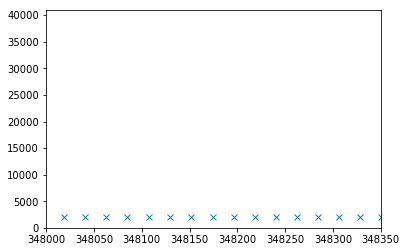

In [19]:
plt.plot(indices[:-1], freq, 'x')
plt.xlim([348000,348350])
plt.show()

Test with hilbert transform

In [20]:
analytic_signal = hilbert(dataFiltered)
amplitude_envelope = np.abs(analytic_signal)
instantaneous_phase = np.unwrap(np.angle(analytic_signal))
instantaneous_frequency = (np.diff(instantaneous_phase) / (2.0*np.pi) * 44100)

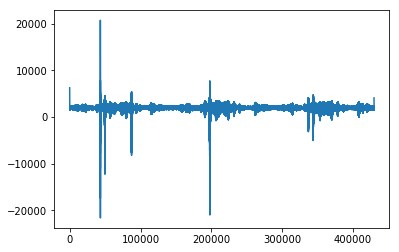

In [21]:
plt.figure()
plt.plot(instantaneous_frequency)
plt.show()

Test Lock In Amplifier

In [22]:
n = len(dataFiltered)
Tt = np.arange(n)/44100
f = 2000
X = np.sin(2*np.pi*f*Tt)
Y = np.cos(2*np.pi*f*Tt)
dataX = dataFiltered*X
dataY = dataFiltered*Y
X_filter = low_pass(dataX, 300, 44100)
Y_filter = low_pass(dataY, 300, 44100)
phi = np.arctan2(X_filter, Y_filter)
phi_bis = np.cumsum((phi[1:]-phi[:-1]+np.pi)%(2*np.pi)-np.pi)

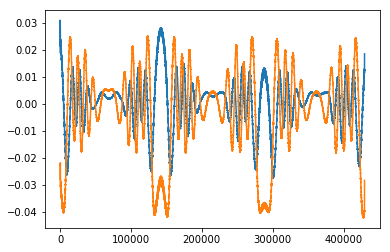

In [23]:
plt.plot(X_filter)
plt.plot(Y_filter)
plt.show()

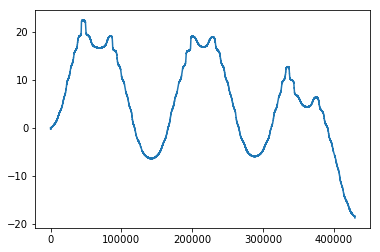

In [24]:
plt.plot(phi_bis)
plt.show()

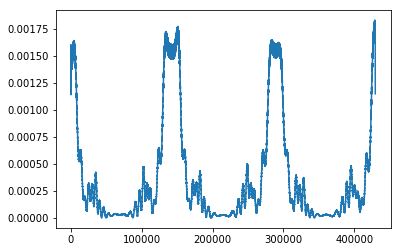

In [25]:
plt.plot(abs(X_filter**2+Y_filter**2))
plt.show()